# <center> NYC-Taxi-Trip-Insights-Revenue-Efficiency-Tip-Prediction </center>

In [2]:
#load libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (10,5)

In [4]:
# load dataset
df = sns.load_dataset("taxis").copy()
df

,pickup,dropoff,passengers,distance,fare,tip,tolls,total,color,payment,pickup_zone,dropoff_zone,pickup_borough,dropoff_borough
0,2019-03-23 20:21:09,2019-03-23 20:27:24,1,1.60,7.0,2.15,0.0,12.95,yellow,credit card,Lenox Hill West,UN/Turtle Bay South,Manhattan,Manhattan
1,2019-03-04 16:11:55,2019-03-04 16:19:00,1,0.79,5.0,0.00,0.0,9.30,yellow,cash,Upper West Side South,Upper West Side South,Manhattan,Manhattan
2,2019-03-27 17:53:01,2019-03-27 18:00:25,1,1.37,7.5,2.36,0.0,14.16,yellow,credit card,Alphabet City,West Village,Manhattan,Manhattan
3,2019-03-10 01:23:59,2019-03-10 01:49:51,1,7.70,27.0,6.15,0.0,36.95,yellow,credit card,Hudson Sq,Yorkville West,Manhattan,Manhattan
4,2019-03-30 13:27:42,2019-03-30 13:37:14,3,2.16,9.0,1.10,0.0,13.40,yellow,credit card,Midtown East,Yorkville West,Manhattan,Manhattan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6428,2019-03-31 09:51:53,2019-03-31 09:55:27,1,0.75,4.5,1.06,0.0,6.36,green,credit card,East Harlem North,Central Harlem North,Manhattan,Manhattan
6429,2019-03-31 17:38:00,2019-03-31 18:34:23,1,18.74,58.0,0.00,0.0,58.80,green,credit card,Jamaica,East Concourse/Concourse Village,Queens,Bronx
6430,2019-03-23 22:55:18,2019-03-23 23:14:25,1,4.14,16.0,0.00,0.0,17.30,green,cash,Crown Heights North,Bushwick North,Brooklyn,Brooklyn
6431,2019-03-04 10:09:25,2019-03-04 10:14:29,1,1.12,6.0,0.00,0.0,6.80,green,credit card,East New York,East Flatbush/Remsen Village,Brooklyn,Brooklyn


In [5]:
# basic cleaning
df['pickup'] = pd.to_datetime(df['pickup'])
df['dropoff'] = pd.to_datetime(df['dropoff'])
df = df.dropna(subset=['pickup','passengers','distance','fare'])   # drop broken rows

# derived cols
df['hour'] = df['pickup'].dt.hour
df['date'] = df['pickup'].dt.date
df['weekday'] = df['pickup'].dt.day_name()            # e.g. Monday
df['weekday_num'] = df['pickup'].dt.weekday 

### 1 — Line plot: rides per hour (24-hour pattern)

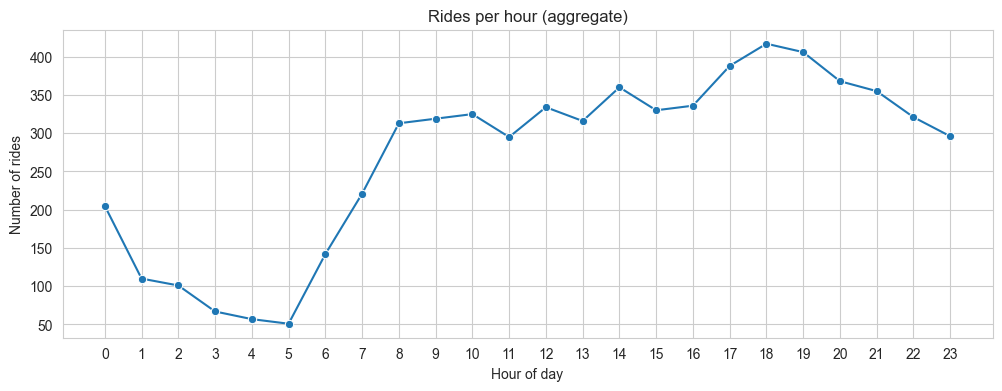

In [6]:
rides_per_hour = df.groupby('hour').size().reset_index(name='rides')

plt.figure(figsize=(12,4))
sns.lineplot(data=rides_per_hour, x='hour', y='rides', marker='o')
plt.xticks(range(0,24))
plt.xlabel('Hour of day')
plt.ylabel('Number of rides')
plt.title('Rides per hour (aggregate)')
plt.grid(True)
plt.show()

####  **Business insights to look for**
- Peak commute hours (commonly 7–9 AM and 5–8 PM) → driver reallocation / surge windows.
- Late-night peaks (e.g., 11pm–2am) indicate nightlife demand — opportunity for premium pricing or safety programs.
- Low-demand windows indicate when to reduce driver headcount or offer driver incentives to take other work.

### 2 — Bar chart: rides per weekday (weekly pattern)

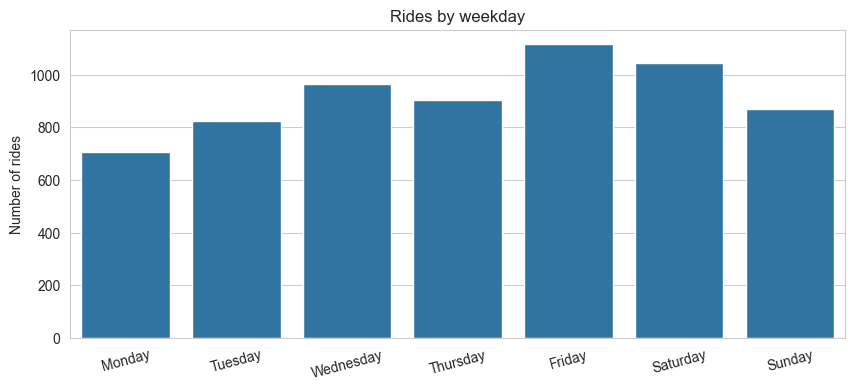

In [7]:
rides_per_weekday = df.groupby(['weekday_num','weekday']).size().reset_index(name='rides')
rides_per_weekday = rides_per_weekday.sort_values('weekday_num')

plt.figure(figsize=(10,4))
sns.barplot(data=rides_per_weekday, x='weekday', y='rides')
plt.xlabel('')
plt.ylabel('Number of rides')
plt.title('Rides by weekday')
plt.xticks(rotation=15)
plt.show()


#### **Business insights to look for**
- Weekend uplift (Sat/Sun) suggests leisure demand — could change pricing & promotions.
- Midweek slump (Tue/Wed) might be target for promotions or business-customer incentives.
- If Monday is high in morning but low overall, it may reflect commute patterns only.

### 3 — Heatmap: pickup zone vs hour (demand distribution by zone & hour)

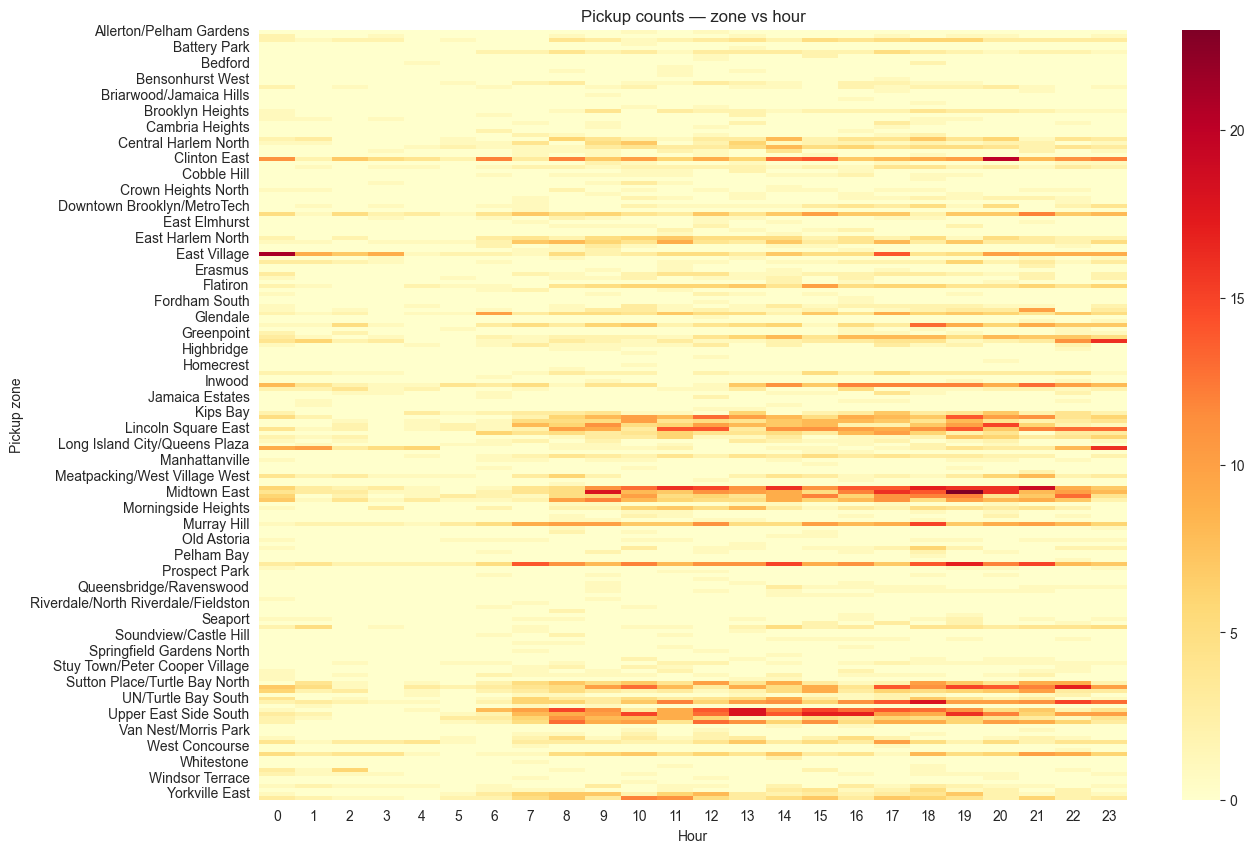

In [8]:
# pivot: rows zones, cols hours
pivot = df.pivot_table(index='pickup_zone', columns='hour', values='distance', aggfunc='count', fill_value=0)
# normalize by row to show relative hourly share across zones (optional)
pivot_norm = pivot.div(pivot.sum(axis=1), axis=0).fillna(0)

plt.figure(figsize=(14,10))
sns.heatmap(pivot, cmap="YlOrRd", fmt="g")         # raw counts heatmap
plt.title('Pickup counts — zone vs hour')
plt.xlabel('Hour')
plt.ylabel('Pickup zone')
plt.show()


<Axes: xlabel='hour', ylabel='pickup_zone'>

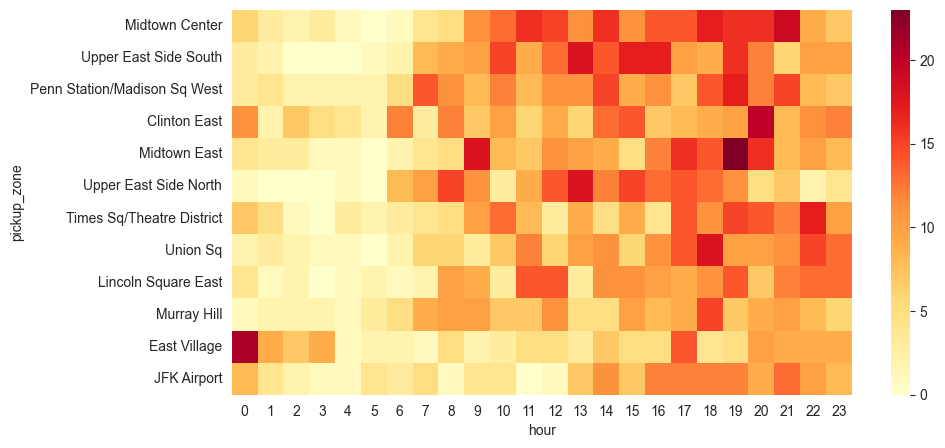

In [9]:
#If many zones, show top-N zones first:

top_zones = df['pickup_zone'].value_counts().nlargest(12).index
pivot_top = pivot.loc[top_zones]
sns.heatmap(pivot_top, cmap="YlOrRd")

#### **Business insights to look for**
- Airport zones showing strong early-morning/late-night spikes → dedicated shuttle/service or pricing.
- Business districts concentrated in 8–10 AM & 5–7 PM → opportunity for scheduled pickups or corporate plans.
- Nightlife zones with late peaks → safety features, surge staffing, partnerships with venues.

### 4 — Hourly rides time series (daily granularity) — identify trends & anomalies

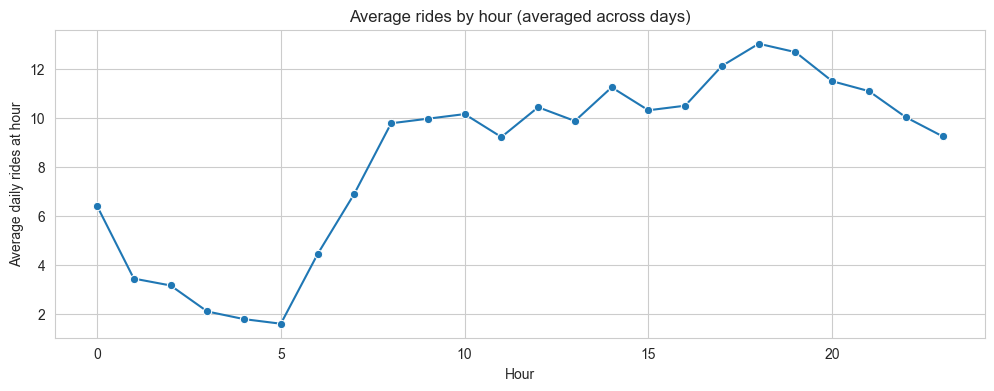

In [10]:
daily_hourly = df.set_index('pickup').groupby([pd.Grouper(freq='D'), 'hour']).size().unstack(fill_value=0)
# plot aggregated daily average by hour
avg_by_hour = daily_hourly.mean(axis=0)
plt.figure(figsize=(12,4))
sns.lineplot(x=avg_by_hour.index, y=avg_by_hour.values, marker='o')
plt.title('Average rides by hour (averaged across days)')
plt.xlabel('Hour')
plt.ylabel('Average daily rides at hour')
plt.show()

#### **Business insights**
- Confirms recurring demand windows vs one-off spikes; useful for staffing forecasts.
- If weekday vs weekend patterns differ, plan separate schedules.

### 5 — Top pickup zones (bar chart) — where the volume comes from

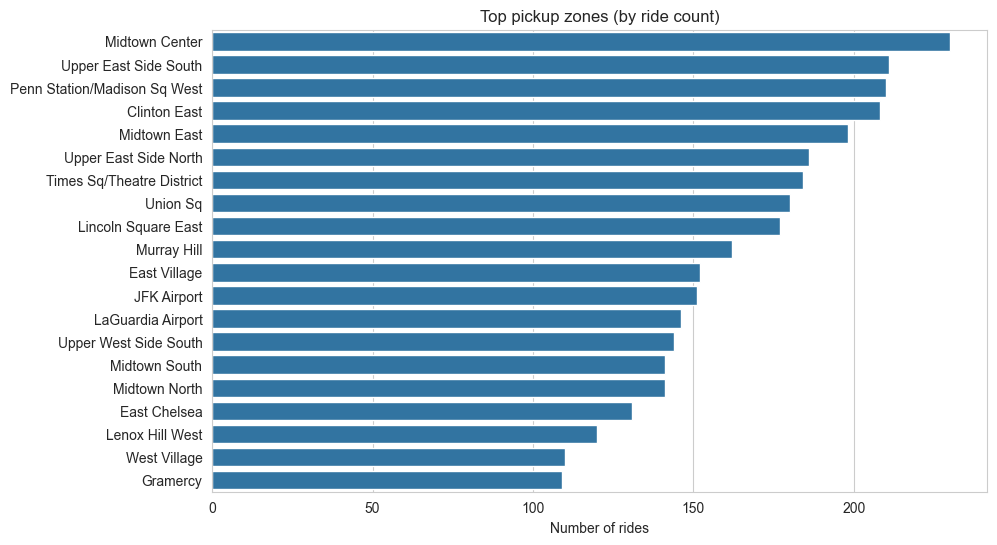

In [11]:
top_zones = df['pickup_zone'].value_counts().nlargest(20).reset_index()
top_zones.columns = ['pickup_zone','rides']
plt.figure(figsize=(10,6))
sns.barplot(data=top_zones, y='pickup_zone', x='rides')
plt.title('Top pickup zones (by ride count)')
plt.xlabel('Number of rides')
plt.ylabel('')
plt.show()


#### **Business insights**
- Concentrate marketing / driver allocation to top zones first.
- If top zones are clustered geographically, consider micro-hubs or driver staging areas.
- Correlate revenue per zone later to find highest-value vs highest-volume zones.

### 6 — Weekday × hour heatmap (aggregate across all zones) — show commute patterns

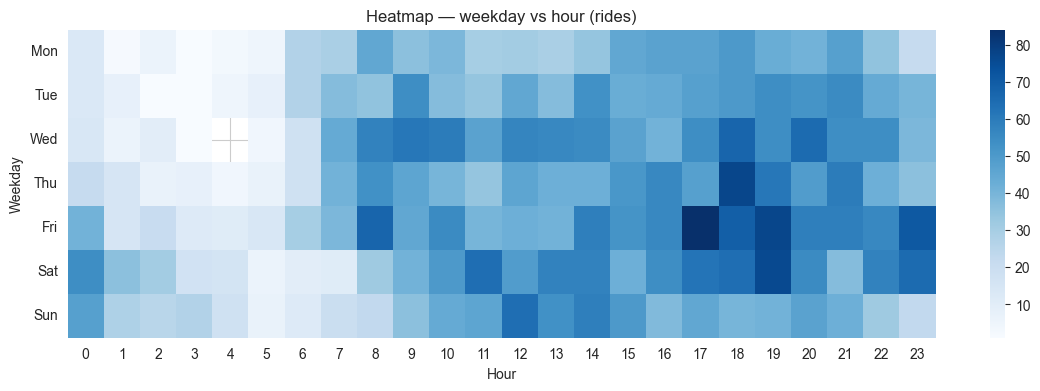

In [12]:
wk_hr = df.groupby(['weekday_num','hour']).size().reset_index(name='rides')
pivot_wk_hr = wk_hr.pivot(index='weekday_num', columns='hour', values='rides').sort_index()

plt.figure(figsize=(14,4))
sns.heatmap(pivot_wk_hr, cmap='Blues')
plt.yticks(np.arange(7)+0.5, ['Mon','Tue','Wed','Thu','Fri','Sat','Sun'], rotation=0)
plt.title('Heatmap — weekday vs hour (rides)')
plt.xlabel('Hour')
plt.ylabel('Weekday')
plt.show()


#### **Business insights**
- Identify weekday-specific strategies (e.g., Friday nightlife staffing, Monday morning commuter promotions).
- Identify days with sustained demand throughout the day (tourist areas).

### 7 — Top zones by hour — small multiples for top zones (trend per zone)

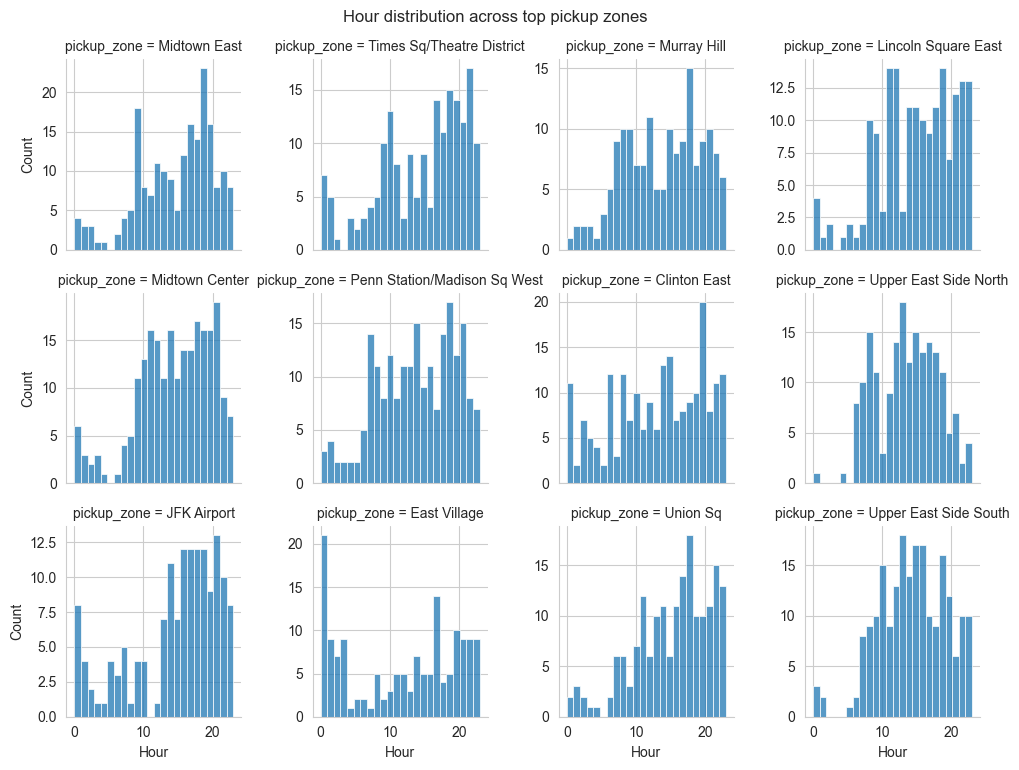

In [14]:
top_zones = df['pickup_zone'].value_counts().nlargest(12).index
df_top = df[df['pickup_zone'].isin(top_zones)]

g = sns.FacetGrid(df_top, col='pickup_zone', col_wrap=4, height=2.5, sharey=False)
g.map_dataframe(lambda data, color: sns.histplot(data['hour'], bins=24))
g.set_axis_labels('Hour', 'Count')
g.fig.suptitle('Hour distribution across top pickup zones', y=1.02)
plt.show()


#### **Business insights**
- Tailor driver shifts per zone (drivers in Zone A should expect early-morning rush; Zone B late-night).
- Create zone-level incentives.

### 8 — Rolling 7-day demand trend (detect growth/decline)

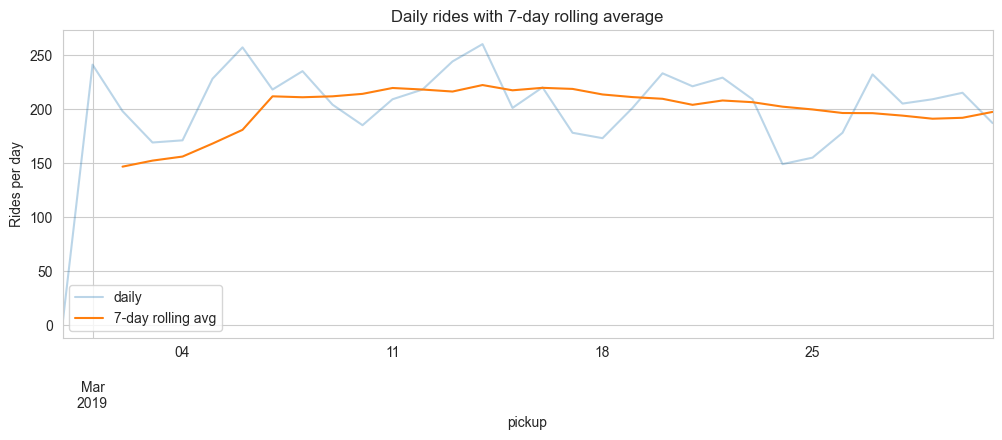

In [15]:
daily = df.set_index('pickup').resample('D').size().rename('rides')
rolling = daily.rolling(window=7, min_periods=3).mean()

plt.figure(figsize=(12,4))
daily.plot(alpha=0.3, label='daily')
rolling.plot(label='7-day rolling avg')
plt.legend()
plt.title('Daily rides with 7-day rolling average')
plt.ylabel('Rides per day')
plt.show()


#### **Business insights**
- Detect long-term growth or decline in bookings.
- Spot anomalies (spikes) that might indicate events or data issues to investigate.

### 9 — Demand Elasticity check: fraction of rides by payment type over hours (segmentation)

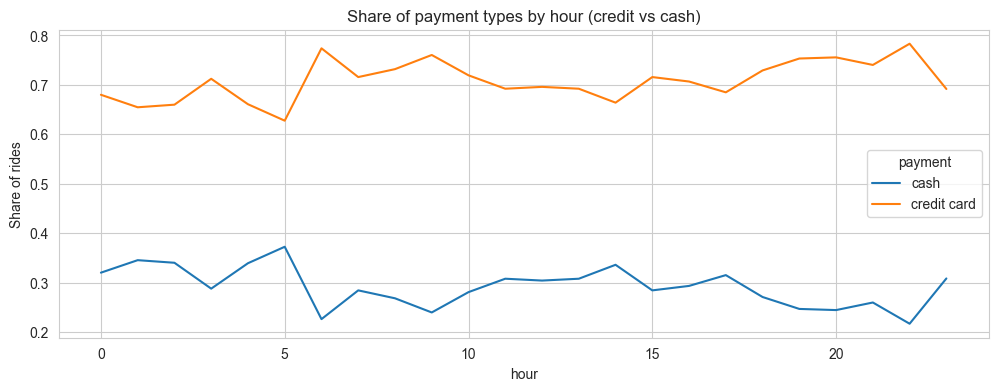

In [16]:
pt = df.groupby(['hour','payment']).size().reset_index(name='rides')
pt_total = pt.groupby('hour')['rides'].transform('sum')
pt['share'] = pt['rides'] / pt_total

plt.figure(figsize=(12,4))
sns.lineplot(data=pt, x='hour', y='share', hue='payment')
plt.title('Share of payment types by hour (credit vs cash)')
plt.ylabel('Share of rides')
plt.show()


#### **Business insights**
- If credit usage correlates with higher tips, focus promotions for card users or integrate loyalty.
- If cash spikes at certain hours/zones, consider cash-handling operational changes.

In [17]:
#Rides by passenger count: 
df['passengers'].value_counts()

passengers
1    4678
2     876
5     277
3     243
6     153
4     110
0      96
Name: count, dtype: int64

In [18]:
#Avg fare by hour:
df.groupby('hour')['fare'].mean()

hour
0     14.039024
1     12.150000
2     12.069307
3     12.470149
4     15.447368
5     16.774510
6     13.296761
7     13.099729
8     12.224473
9     12.865423
10    12.994985
11    12.738847
12    13.496018
13    12.506297
14    13.929556
15    14.088091
16    14.826190
17    13.723995
18    12.362206
19    12.196232
20    12.083560
21    13.040479
22    12.446449
23    13.199358
Name: fare, dtype: float64

In [19]:
#Avg tip_pct by zone:
df.groupby('pickup_zone')['tip'].sum() / df.groupby('pickup_zone')['fare'].sum()

pickup_zone
Allerton/Pelham Gardens    0.000000
Alphabet City              0.180651
Astoria                    0.069077
Auburndale                 0.000000
Battery Park               0.000000
                             ...   
Woodlawn/Wakefield         0.000000
Woodside                   0.076228
World Trade Center         0.150220
Yorkville East             0.198736
Yorkville West             0.186724
Length: 194, dtype: float64

In [20]:
#Proportion of cancellations / zero-fare rows (data quality): 
df[df['fare']<=0].shape[0]

0